# Precio del Maíz en Chile

In [65]:
#Cargamos librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_process import arma_generate_sample, ArmaProcess
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
import statsmodels
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_model import ARMA
from statsmodels.stats.diagnostic import acorr_ljungbox 
import pylab
import scipy.stats as stats


#Funciones a utilizar

def test_stationarity(timeseries):
    
    #Determinación de la media móvil
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Graficando la media móvil:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Media móvil')
    std = plt.plot(rolstd, color='black', label = 'Desviación estándar móvil')
    plt.legend(loc='best')
    plt.title('Média móvil y desviación estándar')
    plt.show(block=False)
    
    #Aplicación del test de Dickey-Fuller:
    print('Resultados del test de Dickey-Fuller:')
    dftest = adfuller(timeseries, regression="nc")
    dfoutput = pd.Series(dftest[0:4], index=['Estadístico de Prueba','valor-p','#Retardos utilizados','Número de observaciones utilizado'])
    for key,value in dftest[4].items():
        dfoutput['Valor crítico (%s)'%key] = value
    print(dfoutput)

def tsdisplay(y, figsize = (14, 8), title = "", lags = 20):
    tmp_data = pd.Series(y)
    fig = plt.figure(figsize = figsize)
    #Plot the time series
    tmp_data.plot(ax = fig.add_subplot(311), title = "Residuos de modelo", legend = False)
    #Plot the ACF:
    sm.graphics.tsa.plot_acf(tmp_data, lags = lags, zero = False, ax = fig.add_subplot(323))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the PACF:
    sm.graphics.tsa.plot_pacf(tmp_data, lags = 20, zero = False, ax = fig.add_subplot(324))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the QQ plot of the data:
    sm.qqplot(tmp_data, line='s', ax = fig.add_subplot(325)) 
    plt.title("QQ Plot")
    #Plot the residual histogram:
    fig.add_subplot(326).hist(tmp_data, bins = 40)
    plt.title("Histogram")
    #Fix the layout of the plots:
    plt.tight_layout()
    plt.savefig("resid-display-arma21.png",dpi=200)
    
def tsdiag(y, figsize = (14, 8), title = "", lags = 10):
    tmp_data = pd.Series(y)
    #tmp_data.index += 1
    tmp_acor = list(acorr_ljungbox(tmp_data, lags = lags, boxpierce = True))
    # Plot Ljung-Box and Box-Pierce statistic p-values:
    plt.plot(range(1, len(tmp_acor[0]) + 1), tmp_acor[1], 'bo', label = "Ljung-Box values")
    plt.grid()
    #plt.plot(range(1, len(tmp_acor[0]) + 1), tmp_acor[3], 'go', label = "Box-Pierce values")
    plt.xticks(np.arange(1,  len(tmp_acor[0]) + 1, 1.0))
    plt.axhline(y = 0.05, color = "red", label = "5% critical value")
    plt.title("p-values Ljung-Box")
    plt.legend()
    #plt.savefig("box-2.png",dpi=200)
    
    # Return the statistics:
    col_index = ["Ljung-Box: X-squared", "Ljung-Box: p-value", "Box-Pierce: X-squared", "Box-Pierce: p-value"]
    return pd.DataFrame(tmp_acor, index = col_index, columns = range(1, len(tmp_acor[0]) + 1))

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = 0                    # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

# Carga de datos

In [66]:
df = pd.read_excel("Maíz ODEPA (4)  Precio real.xlsx", sheet_name="PRECIOS REALES MENSUALES")

df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48
0,Año,Ene,IPM Ene,RAZÓN,P. REAL MENSUAL,Feb,IPM Feb,RAZÓN,P. REAL MENSUAL,Mar,...,RAZÓN,P. REAL MENSUAL,Nov,IPM Nov,RAZÓN,P. REAL MENSUAL,Dic,IPM Dic,RAZÓN,P. REAL MENSUAL
1,1975,280,0.26,1076.92,401025,320,0.3,1066.67,397205,350,...,757.895,282225,900,1.05,857.143,319183,920,1.09,844.037,314302
2,1976,1050,1.24,846.774,315322,1200,1.38,869.565,323809,1180,...,785.496,292503,2058,2.63,782.51,291391,2058,2.75,748.364,278676
3,1977,2058,2.94,700,260666,2058,3.21,641.121,238741,2075,...,631.121,235017,2842,4.48,634.375,236229,2842,4.54,625.991,233107
4,1978,3200,4.63,691.145,257368,3200,4.82,663.9,247223,3367,...,873.786,325381,5400,6.29,858.506,319690,5000,6.31,792.393,295071


In [67]:
df.columns = list(df.loc[0])

## Obtenemos serie de precios nominales para hacer comparación con precios reales

In [68]:
meses = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic ']
df_nominal = df[meses]

In [69]:
df_nominal.head()

,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
0,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
1,280,320,350,350,335,340,500,650,680,720,900,920
2,1050,1200,1180,1200,1500,1800,1847,1900,2013,2058,2058,2058
3,2058,2058,2075,2392,2575,2733,2842,2842,2842,2758,2842,2842
4,3200,3200,3367,4000,4167,4250,4650,5200,5350,5400,5400,5000


In [70]:
df_nominal = df_nominal.drop([0])

In [71]:
df_nominal.index = list(range(len(df_nominal)))

In [72]:
precios_nominales = []
for i in range(len(df_nominal)):
    for j in range(len(df_nominal.columns)):
        precios_nominales.append(df_nominal.loc[i][j]) 

In [73]:
ts_nom = pd.DataFrame()
ts_nom["Precio"] = precios_nominales
ts_nom.index = pd.date_range("01/1975","01/2021", freq='m') 

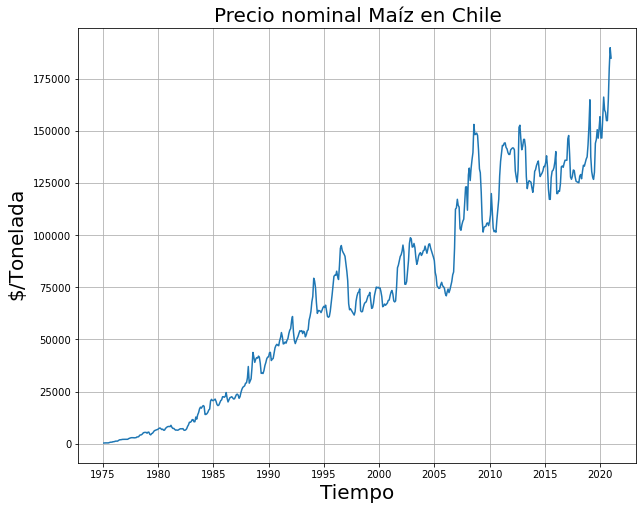

In [74]:
rcParams['figure.figsize'] = 10, 8

plt.plot(ts_nom)
plt.title("Precio nominal Maíz en Chile", fontsize=20)
plt.ylabel("$\$$/Tonelada", fontsize=20)
plt.xlabel("Tiempo", fontsize=20)
plt.grid()
#plt.savefig('nominal.png',dpi=200)

## Precios Reales del maíz

In [75]:
datos = df["P. REAL MENSUAL"]

In [76]:
datos=datos.drop([0])

In [77]:
datos.index = list(range(len(datos)))

In [78]:
precios = []
for i in range(len(datos)):
    for j in range(len(datos.columns)):
        precios.append(datos.loc[i][j])           

In [79]:
len(precios)

552

In [80]:
ts = pd.DataFrame()
ts["Precio"] = precios
ts.index = pd.date_range("01/1975","01/2021", freq='m') 

In [81]:
ts = ts[3:]
len(ts)

549

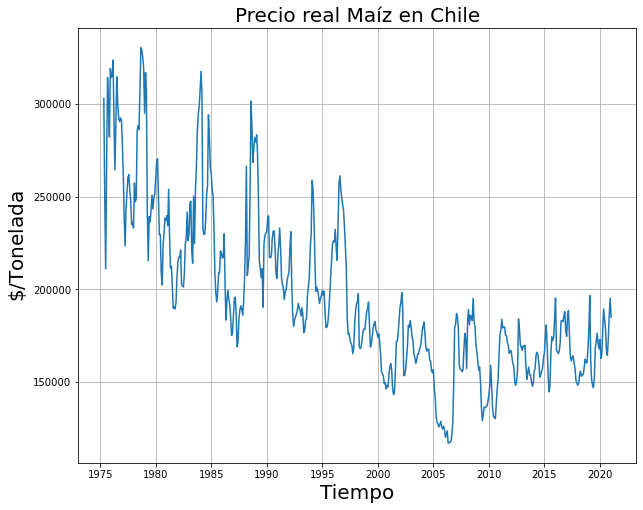

In [82]:
rcParams['figure.figsize'] = 10, 8

plt.plot(ts)
plt.title("Precio real Maíz en Chile", fontsize = 20)
plt.ylabel("$\$$/Tonelada", fontsize=20)
plt.xlabel("Tiempo", fontsize=20)
plt.grid()
#plt.savefig('real.png',dpi=200)

## Obtención de los datos

Los datos fueron obtenidos del sitio web de la Oficina de estudios y políticas agrarias (ODEPA) del ministerio de agricultura. A los datos se les realizó un procesamiento, debido a que representaban los precios nominales, por lo que hubo que ajustarlos a precio real, considerando datos del índice de Precios al por mayor (IPM), dichos datos fueron obtenidos del Instituto Nacional de Estadísticas. Finamente trabajaremos con los datos de precio real del maíz, en periodos mensuales desde el año 1975 al año 2020



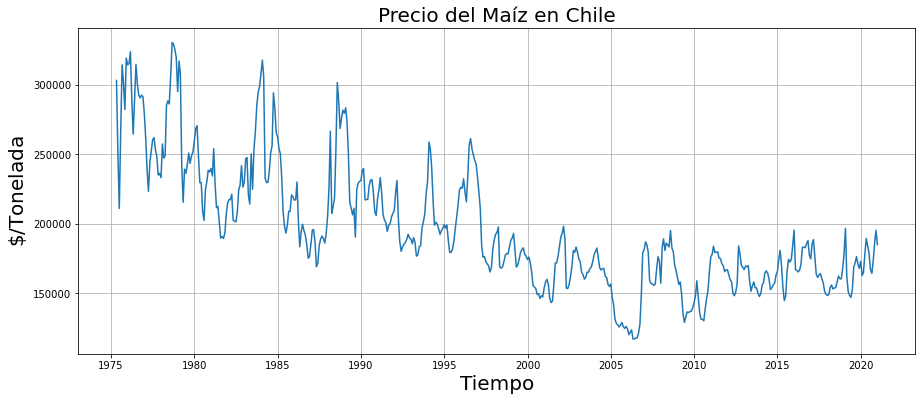

In [83]:
rcParams['figure.figsize'] = 15, 6

plt.plot(ts)
plt.title("Precio del Maíz en Chile", fontsize = 20)
plt.ylabel("$\$$/Tonelada", fontsize=20)
plt.xlabel("Tiempo", fontsize=20)
plt.grid()
#plt.savefig('serie_maiz.png',dpi=200)

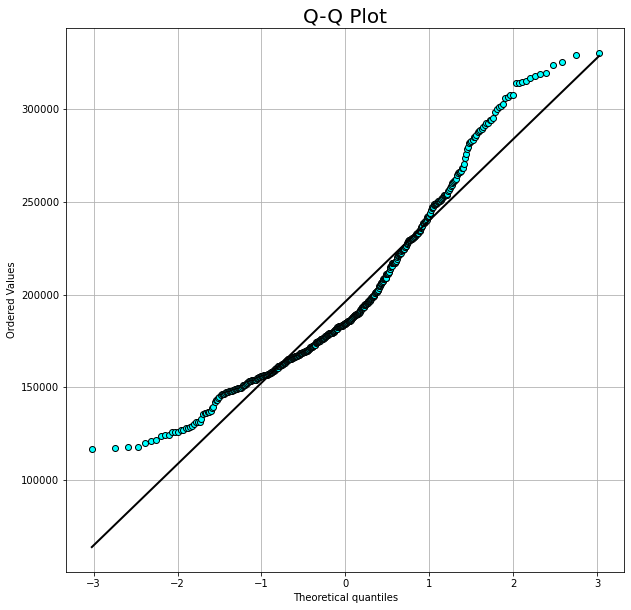

In [84]:
rcParams['figure.figsize'] = 10, 10

fig = plt.figure()
ax = fig.add_subplot(111)
fig = stats.probplot(ts["Precio"].values, dist="norm", plot=pylab)
ax.get_lines()[0].set_marker('o')
ax.get_lines()[0].set_color('black')
ax.get_lines()[0].set_markerfacecolor('cyan')
ax.get_lines()[1].set_color('black')
ax.get_lines()[1].set_linewidth('2')
plt.title("Q-Q Plot", fontsize=20)
plt.grid()
plt.savefig("qqplot.png", dpi=200)

In [85]:
from scipy import stats
print("Con el test de Shapiro-Wilk obtenemos un p-valor:", stats.shapiro(ts)[1])

Con el test de Shapiro-Wilk obtenemos un p-valor: 4.1862052154806664e-14


<Figure size 720x720 with 0 Axes>

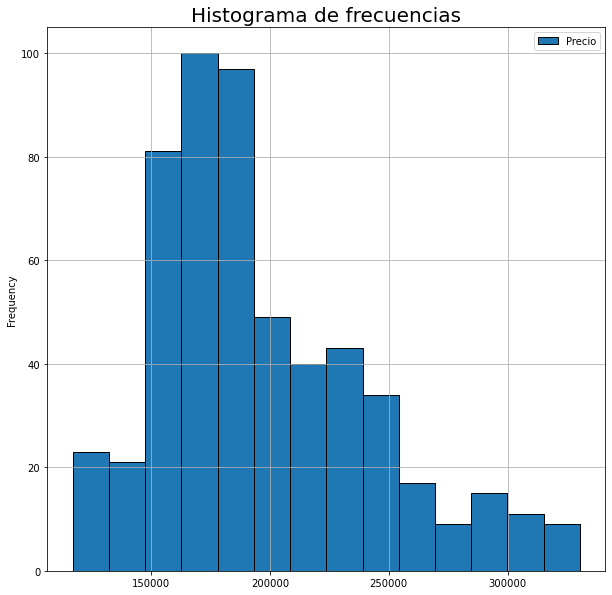

In [86]:
plt.figure()
fig = ts.plot.hist(bins=14, edgecolor="black").get_figure()
plt.title("Histograma de frecuencias", fontsize=20)
plt.grid()
#fig.savefig("hist.png",dpi=200)

<AxesSubplot:ylabel='Density'>

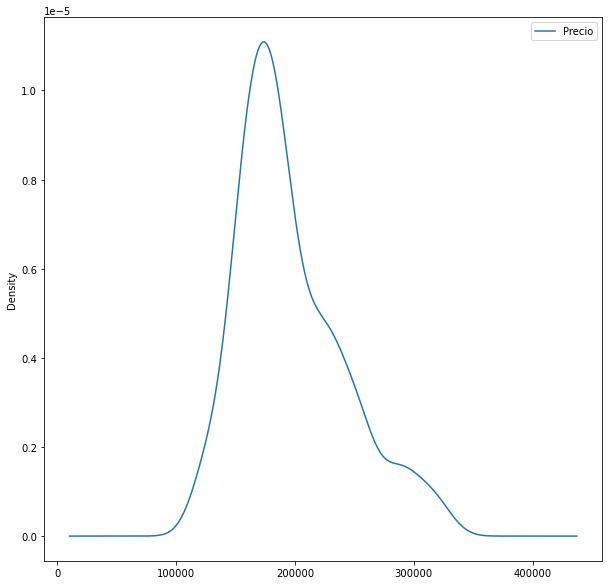

In [87]:
ts.plot.density()

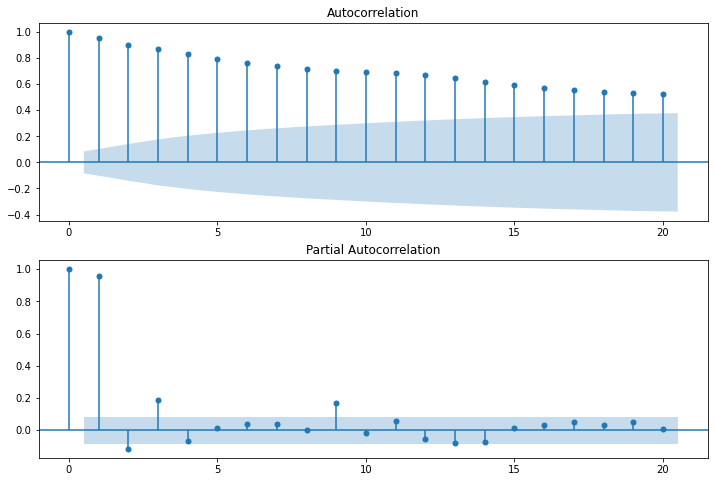

In [88]:
rcParams['figure.figsize'] = 15, 6

fig=plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(ts.dropna(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(ts.dropna(), lags=20, ax=ax2)
#plt.savefig("ACF-PACF.png",dpi=200)
plt.show()


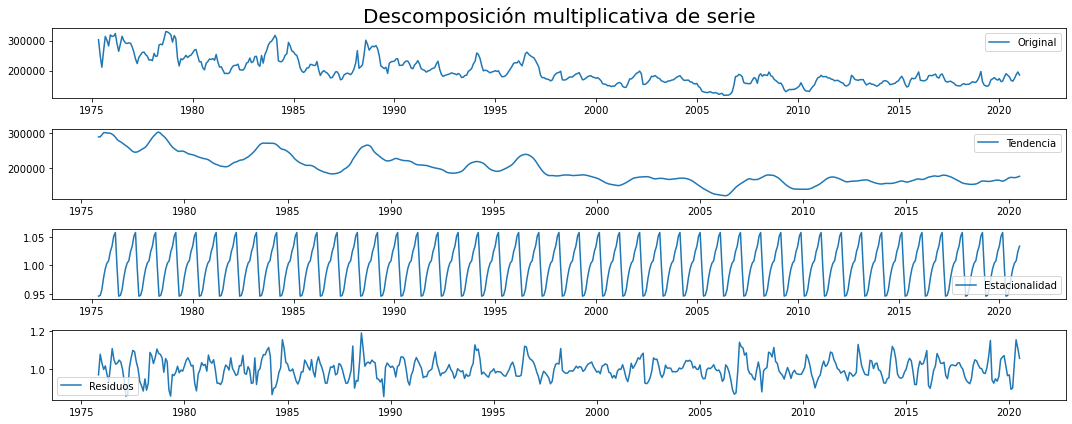

In [89]:

decomposition = seasonal_decompose(ts, model="multiplicative")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.title("Descomposición multiplicativa de serie", fontsize=20)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Estacionalidad')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuos')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("decomp.png",dpi=200)

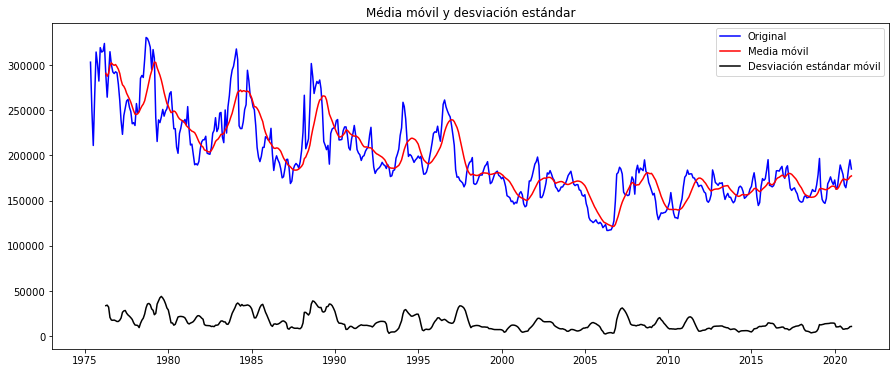

Resultados del test de Dickey-Fuller:
Estadístico de Prueba                 -1.034869
valor-p                                0.274221
#Retardos utilizados                  12.000000
Número de observaciones utilizado    536.000000
Valor crítico (1%)                    -2.569924
Valor crítico (5%)                    -1.941513
Valor crítico (10%)                   -1.616334
dtype: float64


In [90]:
test_stationarity(ts)

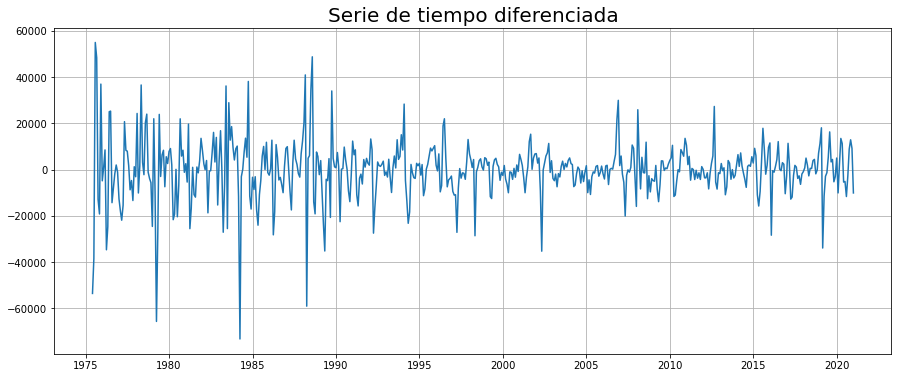

In [91]:
ts_diff = ts.diff().dropna()
plt.plot(ts_diff)
plt.title("Serie de tiempo diferenciada",fontsize=20)
plt.grid()
#plt.savefig("ts_diff.png",dpi=200)

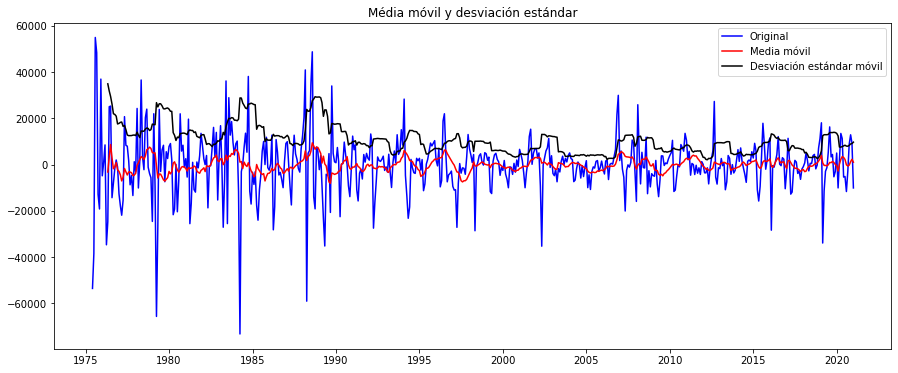

Resultados del test de Dickey-Fuller:
Estadístico de Prueba               -7.102093e+00
valor-p                              3.574891e-11
#Retardos utilizados                 1.300000e+01
Número de observaciones utilizado    5.340000e+02
Valor crítico (1%)                  -2.569940e+00
Valor crítico (5%)                  -1.941515e+00
Valor crítico (10%)                 -1.616332e+00
dtype: float64


In [92]:
test_stationarity(ts_diff)

In [93]:
auto_arima(ts_diff, information_criterion="aic")

ARIMA(order=(1, 0, 3), scoring_args={}, suppress_warnings=True)

In [94]:
model = ARIMA(ts_diff, order=(1,0,3),freq="M").fit()

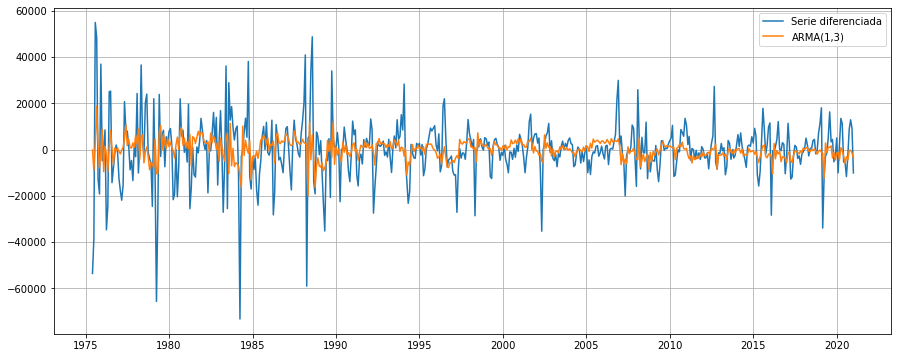

In [95]:
plt.plot(ts_diff, label="Serie diferenciada")
plt.plot(model.fittedvalues, label="ARMA(1,3)")
plt.grid()
plt.legend()
#plt.savefig("diff_arma13.png",dpi=200)

In [96]:
model.aic

11858.840439463027

In [97]:
# Análisis de residuos del proceso ARMA(1,3)

In [98]:
np.mean(model.resid)

-153.47134517829372

In [99]:
np.std(model.resid)

11994.309791758877

In [100]:
print("Con el test de Shapiro-Wilk obtenemos un p-valor:", stats.shapiro(model.resid)[1])

Con el test de Shapiro-Wilk obtenemos un p-valor: 8.549540288001081e-18


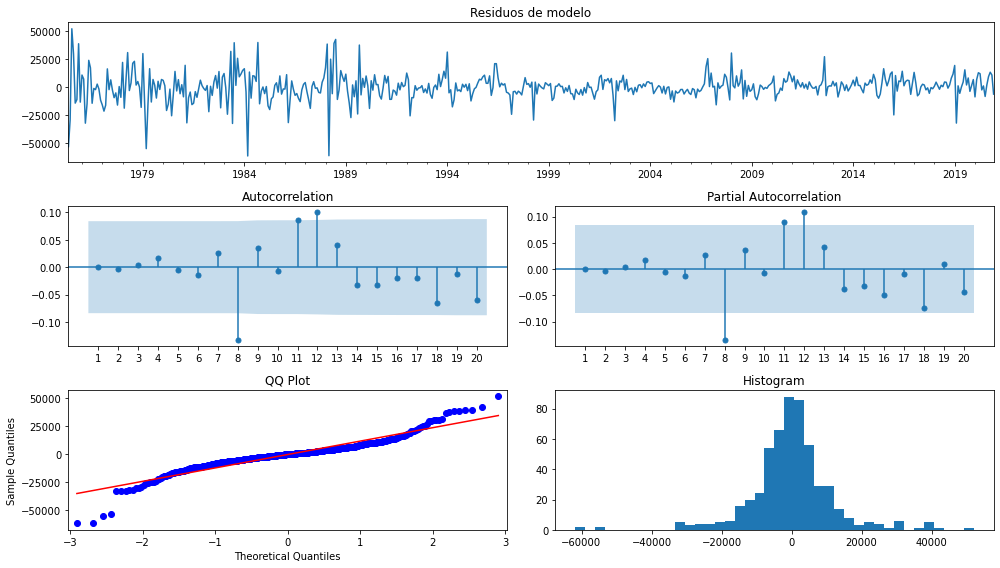

In [101]:
tsdisplay(model.resid)

C:\Users\vicen\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


,1,2,3,4,5,6,7,8,9,10
Ljung-Box: X-squared,0.000144,0.009376,0.017320,0.165159,0.177507,0.282757,0.666005,10.395827,11.081227,11.104959
Ljung-Box: p-value,0.990414,0.995323,0.999397,0.996772,0.999337,0.999576,0.998584,0.238335,0.270182,0.349399
Box-Pierce: X-squared,0.000144,0.009309,0.017180,0.163406,0.175597,0.279316,0.656293,10.209209,10.880901,10.904115
Box-Pierce: p-value,0.990440,0.995357,0.999404,0.996839,0.999354,0.999591,0.998649,0.250648,0.283961,0.365037


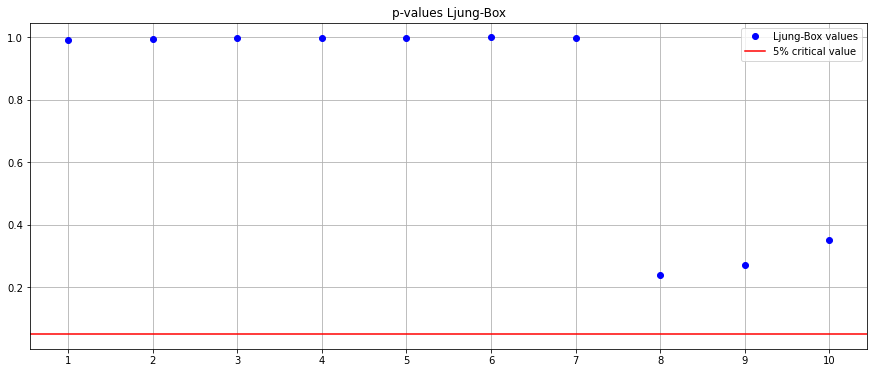

In [102]:
rcParams['figure.figsize'] = 15, 6

tsdiag(model.resid)


In [103]:
model = ARMA(ts_diff, order=(1,3), freq="M").fit()

C:\Users\vicen\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [104]:
# Análisis de residuos de modelo ARMA(1,3)

In [105]:
print("Con el test de Shapiro-Wilk obtenemos un p-valor:", stats.shapiro(model.resid)[0])

Con el test de Shapiro-Wilk obtenemos un p-valor: 0.9068903923034668


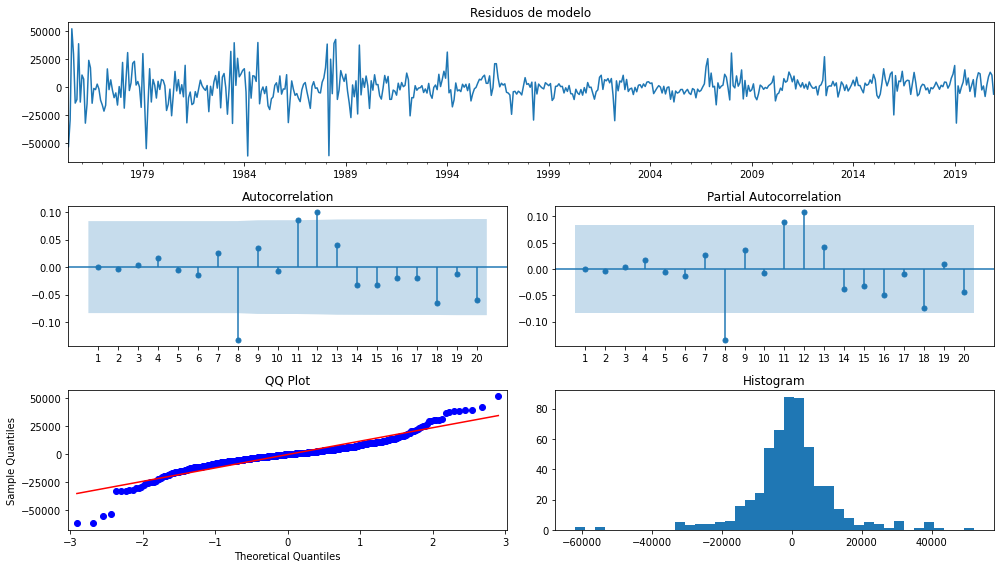

In [106]:
tsdisplay(model.resid)

C:\Users\vicen\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


,1,2,3,4,5,6,7,8,9,10
Ljung-Box: X-squared,0.000144,0.009793,0.017314,0.162801,0.175825,0.283167,0.661708,10.414167,11.093150,11.117950
Ljung-Box: p-value,0.990420,0.995115,0.999397,0.996861,0.999352,0.999574,0.998613,0.237151,0.269378,0.348403
Box-Pierce: X-squared,0.000143,0.009722,0.017174,0.161074,0.173933,0.279714,0.652060,10.227202,10.892605,10.916864
Box-Pierce: p-value,0.990446,0.995151,0.999404,0.996926,0.999369,0.999589,0.998678,0.249440,0.283142,0.364032


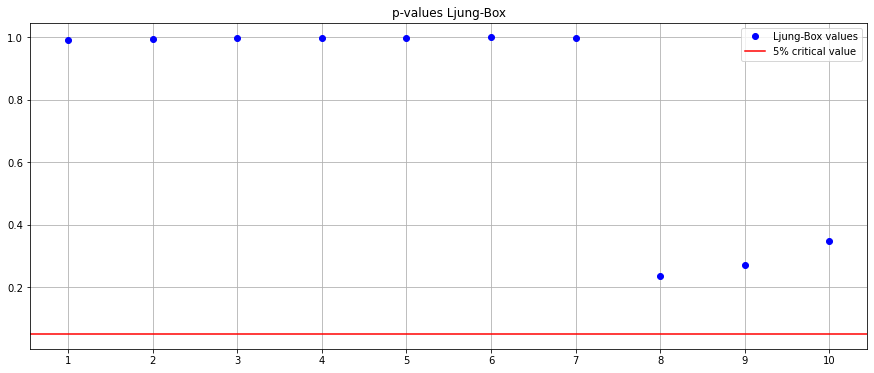

In [107]:
tsdiag(model.resid)

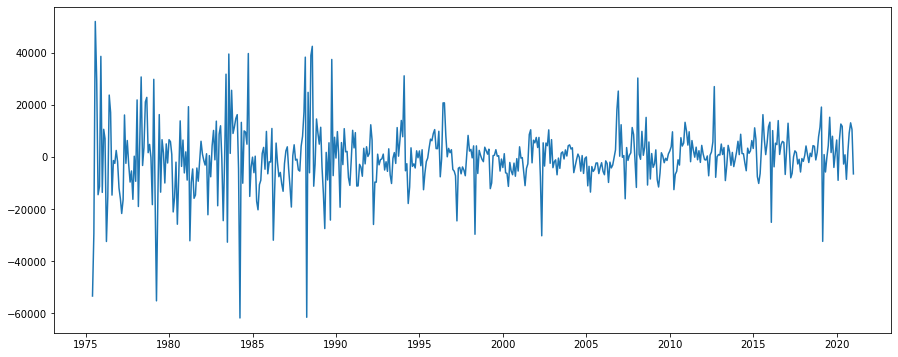

In [108]:
plt.plot(model.resid)

In [109]:
model.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,-211.0150,83.948,-2.514,0.012,-375.549,-46.481
ar.L1.Precio,0.8457,0.038,21.973,0.000,0.770,0.921
ma.L1.Precio,-0.6926,0.059,-11.647,0.000,-0.809,-0.576
ma.L2.Precio,-0.3614,0.050,-7.202,0.000,-0.460,-0.263
ma.L3.Precio,0.0772,0.054,1.420,0.156,-0.029,0.184


# Serie diferenciada desde 1990 para hacer predicciones.

In [110]:
ts_diff["Precio"].index[180]

Timestamp('1990-05-31 00:00:00', freq='M')

In [111]:
ts_show = ts_diff["Precio"]["1990-05-31":]
ts_show

1990-05-31      388.551185
1990-06-30     9711.364455
1990-07-31     4107.380502
1990-08-31       56.450038
1990-09-30    -9202.671659
                  ...     
2020-08-31    -2792.817962
2020-09-30     8779.211380
2020-10-31    12864.389866
2020-11-30     9162.164972
2020-12-31   -10130.036681
Freq: M, Name: Precio, Length: 368, dtype: float64

In [112]:
len(ts_show)

368

Haremos predicción considerando la serie desde 1990

Text(0.5, 1.0, 'Serie diferenciada desde 1900')

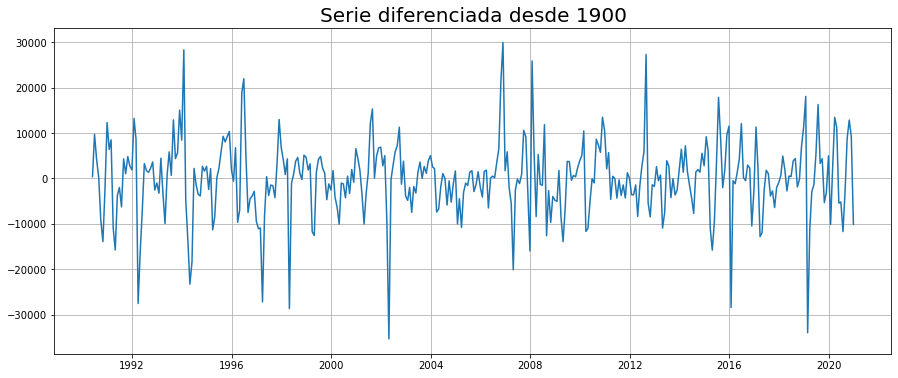

In [113]:
plt.plot(ts_show)
plt.grid()
plt.title("Serie diferenciada desde 1900", fontsize=20)
#plt.savefig("serie1900.png", dpi=200)

Proponemos modelo y hacemos análisis de residuos.

In [114]:
auto_arima(ts_show, information_criterion="aic")

ARIMA(order=(2, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [115]:
model = ARMA(ts_show, order=(2,1), freq="M").fit()

C:\Users\vicen\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [116]:
model.aic

7635.374682970864

In [117]:
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9290627241134644, pvalue=3.270380277350937e-12)

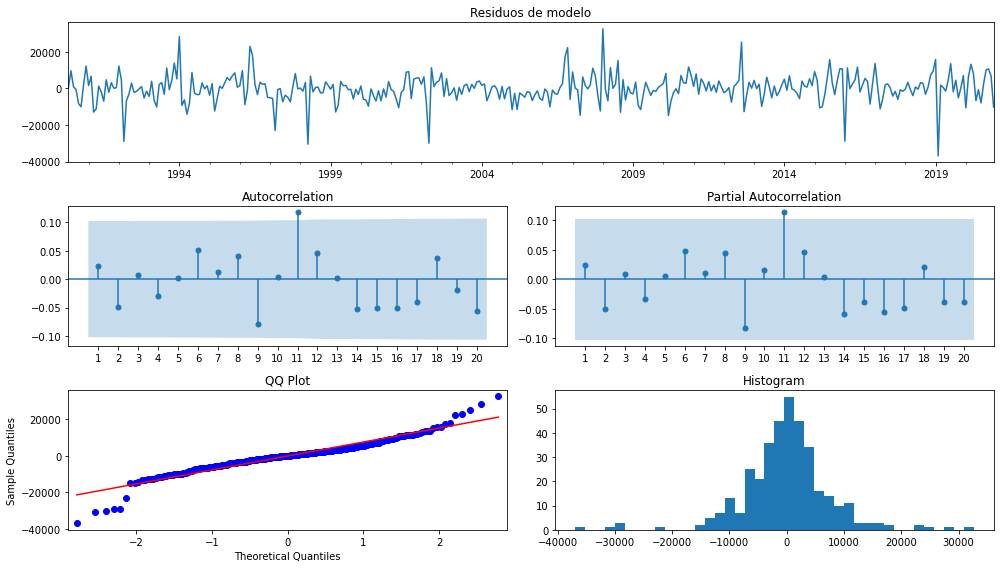

In [118]:
tsdisplay(model.resid)

C:\Users\vicen\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


,1,2,3,4,5,6,7,8,9,10
Ljung-Box: X-squared,0.212006,1.089792,1.106961,1.426983,1.429818,2.395716,2.458636,3.078000,5.438708,5.444508
Ljung-Box: p-value,0.645199,0.579902,0.775394,0.839492,0.921024,0.879951,0.930179,0.929368,0.794512,0.859578
Box-Pierce: X-squared,0.210288,1.078584,1.095520,1.410353,1.413134,2.358148,2.419538,3.022162,5.312687,5.318299
Box-Pierce: p-value,0.646542,0.583161,0.778156,0.842394,0.922871,0.883993,0.933033,0.932959,0.806243,0.868927


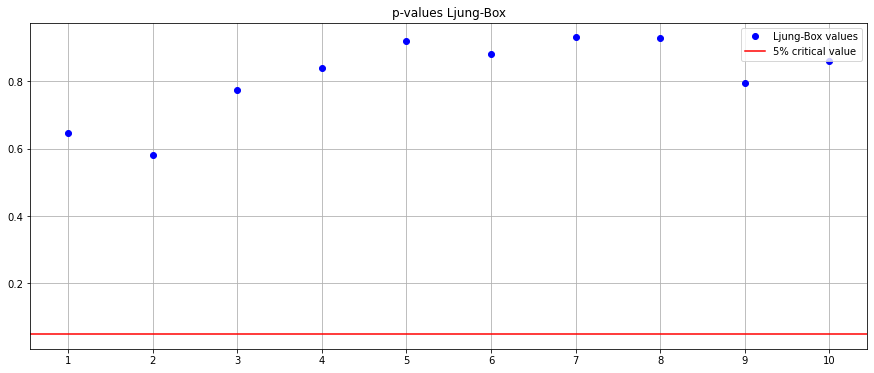

In [119]:
tsdiag(model.resid)

## Quitando el 5% de los datos

In [120]:
len(ts_show)

368

In [121]:
reales = ts_show[len(ts_show)-19:]
reales

2019-06-30     5331.861915
2019-07-31    16278.171965
2019-08-31     3304.158744
2019-09-30     4356.428508
2019-10-31    -5302.179829
2019-11-30    -3080.932908
2019-12-31     4969.628339
2020-01-31   -10120.995682
2020-02-29     1977.764352
2020-03-31    13449.251748
2020-04-30    11252.700973
2020-05-31    -5432.178506
2020-06-30    -5176.998983
2020-07-31   -11684.687260
2020-08-31    -2792.817962
2020-09-30     8779.211380
2020-10-31    12864.389866
2020-11-30     9162.164972
2020-12-31   -10130.036681
Freq: M, Name: Precio, dtype: float64

In [122]:
ts_show_1 = ts_show.iloc[:-18]
ts_show_1

1990-05-31      388.551185
1990-06-30     9711.364455
1990-07-31     4107.380502
1990-08-31       56.450038
1990-09-30    -9202.671659
                  ...     
2019-02-28   -33960.623228
2019-03-31   -11429.956281
2019-04-30    -2916.811524
2019-05-31    -1364.500669
2019-06-30     5331.861915
Freq: M, Name: Precio, Length: 350, dtype: float64

In [123]:
model_1 = ARMA(ts_show_1, order=(2,1), freq="M").fit()

C:\Users\vicen\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


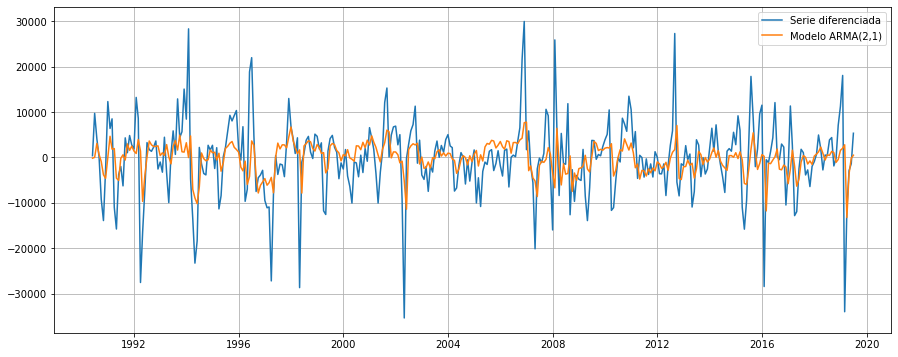

In [124]:
plt.plot(ts_show_1, label="Serie diferenciada")
plt.plot(model_1.fittedvalues, label = "Modelo ARMA(2,1)")
plt.grid()
plt.legend()

In [125]:
prediccion = model_1.predict(start="2019-06-30", end="2020-12-31")

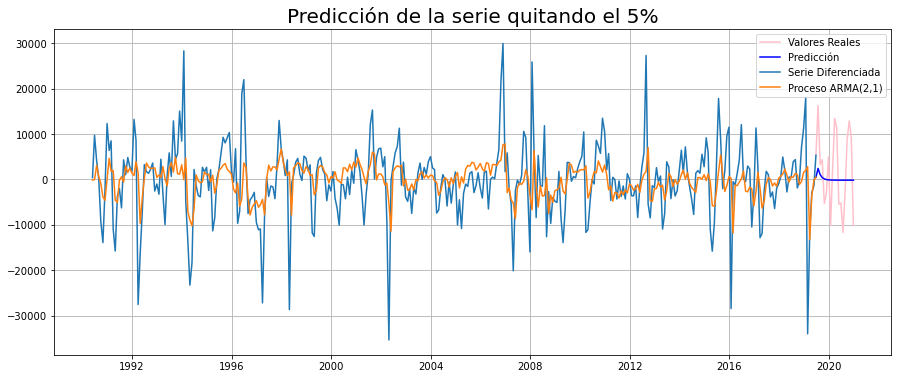

In [126]:

plt.plot(prediccion.index, reales.values, label="Valores Reales", color="pink")
plt.plot(prediccion.index, prediccion.values, label="Predicción", color="blue")
plt.plot(ts_show_1, label="Serie Diferenciada")
plt.plot(model_1.fittedvalues, label="Proceso ARMA(2,1)")
plt.grid()
plt.legend()
plt.title("Predicción de la serie quitando el 5%", fontsize=20)
plt.savefig("pred5.png", dpi=200)

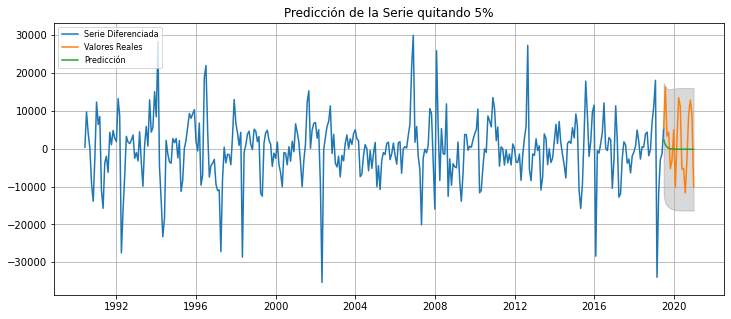

In [127]:
fc, se, conf = model_1.forecast(19, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=prediccion.index)
lower_series = pd.Series(conf[:, 0], index=reales.index)
upper_series = pd.Series(conf[:, 1], index=reales.index)

# Plot
plt.figure(figsize=(12,5))
plt.plot(ts_show_1, label="Serie Diferenciada")
plt.plot(reales.index, reales.values, label="Valores Reales")
plt.plot(fc_series, label='Predicción')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Predicción de la Serie quitando 5%')
plt.legend(loc='upper left', fontsize=8)
plt.grid()
plt.savefig("pred5_1.png",dpi=200)

In [128]:
forecast_accuracy(prediccion, reales)

<ipython-input-65-89ee51d30291>:90: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
<ipython-input-65-89ee51d30291>:91: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-65-89ee51d30291>:92: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],
<ipython-input-65-89ee51d30291>:93: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual

{'mape': 0.9662877651387997,
 'me': -1859.6341889953333,
 'mae': 7433.27448407418,
 'mpe': -0.9662877651387997,
 'rmse': 8423.01563182449,
 'acf1': 0,
 'corr': 0.3921769013455157,
 'minmax': -22.40258529931217}

# Quitando el 10% de los datos finales

In [129]:
# Quitando el 10% de los datos

reales = ts_show[len(ts_show)-39:]

ts_show_2 = ts_show.iloc[:-38]

In [130]:
model_2 = ARMA(ts_show_2, order=(2,1), freq="M").fit()

C:\Users\vicen\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [131]:
prediccion = model_2.predict(start="2017-10-31", end="2020-12-31")


Text(0.5, 1.0, 'Predicción de la serie quitando el 10%')

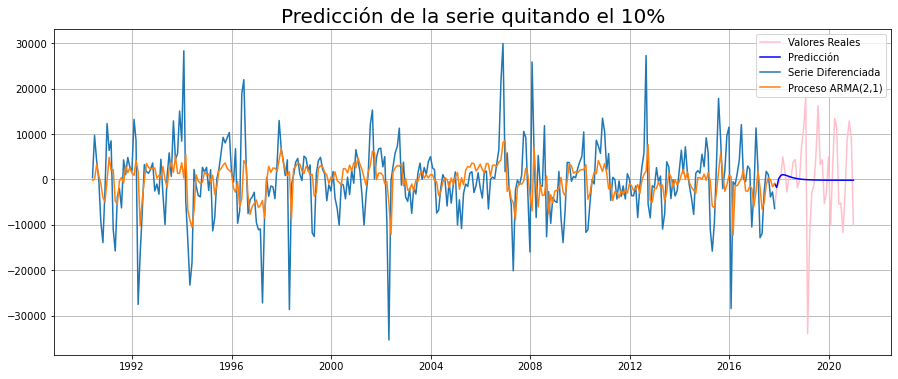

In [132]:
plt.plot(prediccion.index, reales.values, label="Valores Reales", color="pink")
plt.plot(prediccion.index, prediccion.values, label="Predicción", color="blue")
plt.plot(ts_show_2, label="Serie Diferenciada")
plt.plot(model_2.fittedvalues, label="Proceso ARMA(2,1)")
plt.grid()
plt.legend()
plt.title("Predicción de la serie quitando el 10%", fontsize=20)
#plt.savefig("pred10.png", dpi=200)

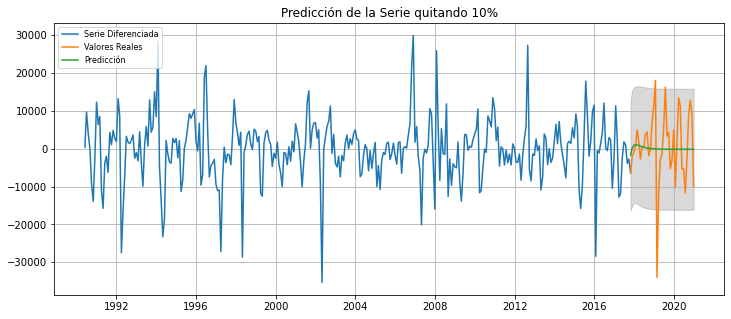

In [133]:
fc, se, conf = model_2.forecast(39, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=prediccion.index)
lower_series = pd.Series(conf[:, 0], index=reales.index)
upper_series = pd.Series(conf[:, 1], index=reales.index)

# Plot
plt.figure(figsize=(12,5))
plt.plot(ts_show_2, label="Serie Diferenciada")
plt.plot(reales.index, reales.values, label="Valores Reales")
plt.plot(fc_series, label='Predicción')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Predicción de la Serie quitando 10%')
plt.legend(loc='upper left', fontsize=8)
plt.grid()
plt.savefig("pred10_1.png",dpi=200)

In [134]:
forecast_accuracy(prediccion, reales)

<ipython-input-65-89ee51d30291>:90: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
<ipython-input-65-89ee51d30291>:91: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-65-89ee51d30291>:92: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],
<ipython-input-65-89ee51d30291>:93: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual

{'mape': 0.9195629160127061,
 'me': -696.8319352980022,
 'mae': 6591.87215635828,
 'mpe': -0.883094905647552,
 'rmse': 9233.785634462909,
 'acf1': 0,
 'corr': 0.08748090574942705,
 'minmax': -28.021303012312575}